<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_15_Convolution_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import numpy as np

import torch
import torch.nn as nn

# For Image Processing
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

#Mean & Max Pooling

## Create a Max Pool Instance

In [2]:
# create a pool class instance with the following parameters
poolSize = 3
stride = 3

# Create the instance
p2 = nn.MaxPool2d(poolSize, stride=3)
p3 = nn.MaxPool3d(poolSize, stride=3)

print(p2)
print(p3)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [3]:
# Create an image and apply max pooling

# 2D image
img2 = torch.randn(1,1,30,30)

# 3D image
img3 = torch.randn(1,3,30,30)

# Check all the combinations of image and maxpool dimensionality
img2Pool2 = p2(img2)
print(f"2D image, 2D maxpool: {img2Pool2.shape}")
print()

# 2D image cannot be used in 3d pooling operation: It is impossible
# img2Pool3 = p3(img2)
# print(f"2D image, 3D maxpool: {img2Pool3.shape}")
# print()

img3Pool2 = p2(img3)
print(f"3D image, 2D maxpool: {img3Pool2.shape}")
print()

img3Pool3 = p3(img3)
print(f"3D image, 3D maxpool: {img3Pool3.shape}")
print()

2D image, 2D maxpool: torch.Size([1, 1, 10, 10])

3D image, 2D maxpool: torch.Size([1, 3, 10, 10])

3D image, 3D maxpool: torch.Size([1, 1, 10, 10])



## Create a CNN

In [4]:
# Construct a simple CNN architecture
littlenet = nn.Sequential(

    # The convolution-pool block
    nn.Conv2d(3,10,5,3,2),  # Convolution layer
    nn.ReLU(),              # The activation Function
    nn.AvgPool3d(3,3),      # Average pooling

    # The Feed-Forward Block
    nn.Flatten(),           # Vectorize to het from image to linear
    nn.Linear(588,1),       # Fully-Connected linear layer
    nn.Sigmoid()            # Output Activation
    )

In [5]:
# Test it with some data
img = torch.rand(1,3,128,128)
littlenet(img)
# A dummy number, not trained model

tensor([[0.4672]], grad_fn=<SigmoidBackward0>)

# Image Transforms

In [6]:
# Import the Dataset: CIFAR with 10 categories
cdata = torchvision.datasets.CIFAR10(root="cifar10", download=True)

print(cdata)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


In [7]:
# Check the shape of the dataset
print(cdata.data.shape)

(50000, 32, 32, 3)


In [8]:
# Check the unique categories
print(cdata.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# .targets is a list of targets converted to ints
# print(cdata.targets)
print(len(cdata.targets))

50000


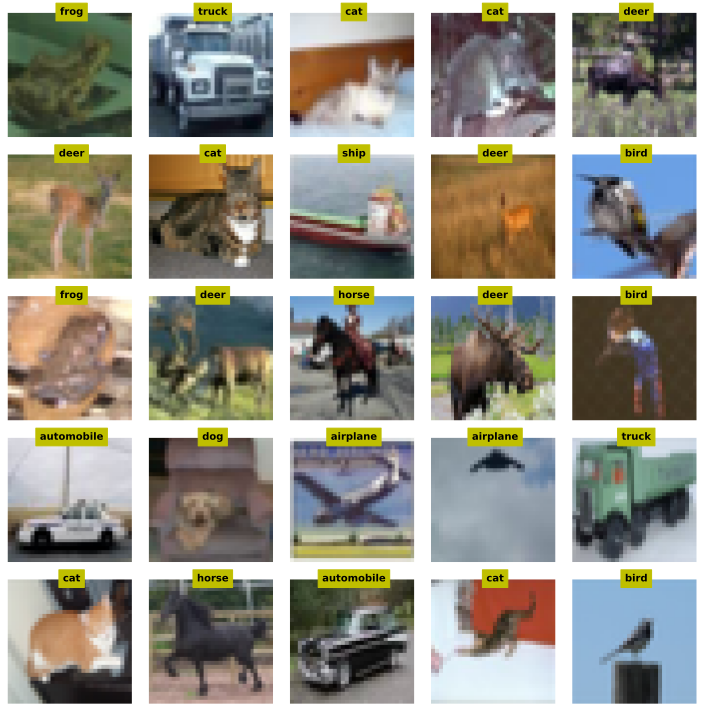

In [10]:
# Lets check a few random images
fig,axs = plt.subplots(5,5,figsize=(10,10))

for ax in axs.flatten():

    # Grab a random picture
    randidx = np.random.choice(len(cdata.targets))

    # Extract the values of that image
    pic = cdata.data[randidx,:,:,:]

    # Get its label
    label = cdata.classes[cdata.targets[randidx]]

    # Plot
    ax.imshow(pic)
    ax.text(16,0,label,ha="center", fontweight="bold", color="k",backgroundcolor="y")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Apply Transformation

In [11]:
# T.Compose object gathers together a bunch of transformations, putting them in order in one object
Ts = T.Compose([
    T.ToTensor(),  # Convert to Pytorch tensor from numpy and pixels 0-1 (normalizing the data)
    T.Resize(32*4),  # Input 32*4: increase the resulution by a factor of 4
    T.Grayscale(num_output_channels=1)  # convert into gray scale
    ])

# Include the transform into the dataset
cdata.transform = Ts

# If you wanna apply the transformation when loading the data:
# cdata = torchvision.datasets.CIFAR10(root="cifar10", download=True, transform=Ts)

# Adding a transform does not change the raw image data
# Transformations are only applied when necessary
print(cdata.data[123,:,:,:].shape)

(32, 32, 3)


In [12]:
# Now apply the transform

# Option 1: Apply the transform externally to an image
img1 = Ts(cdata.data[123,:,:,:])

# Option 2: Use the embedded transform
img2 = cdata.transform(cdata.data[123,:,:,:])

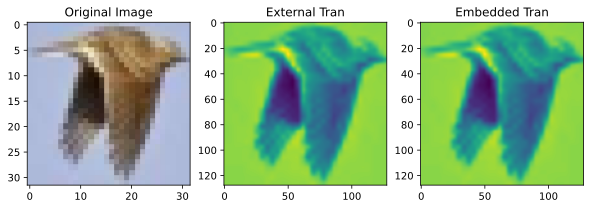

In [13]:
# Plot to see the difference
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(cdata.data[123,:,:,:])
ax[0].set_title("Original Image")
ax[1].imshow(torch.squeeze(img1))
ax[1].set_title("External Tran")
ax[2].imshow(torch.squeeze(img2))
ax[2].set_title("Embedded Tran")

plt.show()

In [14]:
# Range of pixel values to double check transformation on normalization 0-1
print(torch.min(img1), torch.max(img1))

tensor(0.0655) tensor(0.8671)


# Custom DataLoaders

In [15]:
# Step 1: Import the MNIST Dataset
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

# Extract only the first 8 images
labels = data[:8,0]
data = data[:8,1:]

# Normalize 0-1
dataNorm = data/np.max(data)

# Reshape to 2d
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

# Check the sizes
print(dataNorm.shape)
print(labels.shape)

(8, 1, 28, 28)
(8,)


In [16]:
# Step 2: Convert the data into Torch Tensor Format
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

In [17]:
dataT[1,:,:,:].shape

torch.Size([1, 28, 28])

## Customed DataSet Class

In [18]:
# Custom dataset class is modeled after the official class in Pytorch
# ??torch.utils.data.TensorDataset

In [19]:
# Define the class
class customDataset(Dataset):
    def __init__(self, tensors, transform=None):

        # Make sure the size of data and the labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between data and the labels"

        # Assign inputs
        self.tensors = tensors
        # Here we add transformation, not available in the original class
        self.transform = transform

    # What to do when someone wants the item frm the dataset
    def __getitem__(self, index):

        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else:
            x = self.tensors[0][index]

        # Return the label too
        y = self.tensors[1][index]

        return x,y  #(data, label)

    def __len__(self):
        return self.tensors[0].size(0)

In [20]:
# Step 3: Define the transformation
# Transform the data from tensor into custom-transformed dataset
imgtrans = T.Compose([
    T.ToPILImage(),  # PIL is a data format used for several kinds of transformation (works with all formats)
    T.RandomVerticalFlip(p=0.5),  # flip randomly vertically with 1/2 probability
    # T.RandomRotation(90),
    T.ToTensor()  # convert back to pytorch tensor
    ])

In [21]:
# Step 4: Create the DataSet with the transformations you defined
# Now convert to PyTorch Datasets
train_data = customDataset((dataT, labelsT), imgtrans)

In [22]:
type(train_data)

__main__.customDataset

In [23]:
# Step 5: Convert to DataLoader
dataLoaded = DataLoader(train_data, batch_size=8, shuffle=False)

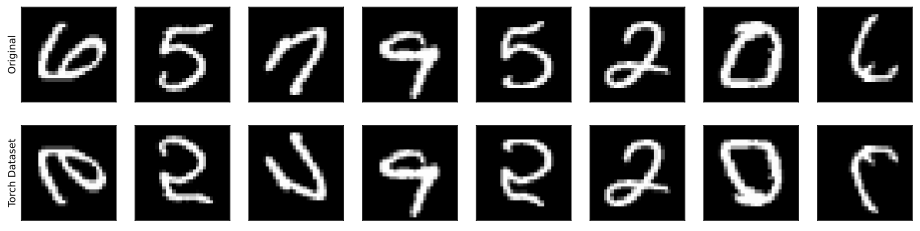

In [24]:
# Import the data from dataloader, similar to training with batches
X,y = next(iter(dataLoaded))

fig,axs = plt.subplots(2,8,figsize=(16,4))

for i in range(8):

    axs[0,i].imshow(dataT[i,0,:,:].detach(),cmap="gray")
    axs[1,i].imshow(X[i,0,:,:].detach(),cmap="gray")

    for row in range(2):
        axs[row,i].set_xticks([])
        axs[row,i].set_yticks([])

# Add row labels
axs[0,0].set_ylabel("Original")
axs[1,0].set_ylabel("Torch Dataset")

plt.show()
# Some data are flipped because of the transformation we applied

In [25]:
# We haven't increased the amount of data: Transfromations are applied when data are pulled from the dataloade
len(train_data)

8